In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
from tqdm import tqdm

# Image paths
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Only process files inside the 'images' folder
    if 'images' in dirname:
        for filename in filenames:
            if filename.endswith('png'):  # Consider only PNG files
                imagePaths.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Deep Learning Tools
from tensorflow.keras import layers, models
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical


# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

This is a kaggle notebook ,so to run this file go to -> https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/code create a new notebook


In [3]:
# Data - Label
Data = []
Target = []
resize = 150

# Label mapping dictionary
cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}

# Iterate through the image paths and assign the labels
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]  # Extract the label from parent folder (2 levels up from image)
    
    if label not in cat:
        continue  # Skip this image if label is not found in dictionary
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) / 255.0  # Normalize image pixels to [0, 1]

    Data.append(image)
    Target.append(cat[label])

print(f"Processed {len(Data)} images with corresponding labels.")

100%|██████████| 21165/21165 [02:18<00:00, 153.30it/s]  

Processed 15153 images with corresponding labels.


In [4]:
print(len(Data))
print(len(Target))

15153
15153


# Label Encoding and to one hot encoding


# examples
[[0., 1., 0.],  # 'Normal' -> [0, 1, 0]

 [0., 0., 1.],  # 'Pneumonia' -> [0, 0, 1]
 
 [1., 0., 0.]]  # 'Covid-19' -> [1, 0, 0]

In [5]:
# encode labels as integers

le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[0. 1. 0.]


In [6]:
# Initial split
(x_train, x_test, y_train, y_test) = train_test_split(Data, labels, test_size=0.20, stratify=labels, random_state=42)

# Further split the training data into training and validation sets
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)


trainX = np.array(x_train)
valX = np.array(x_val)
testX = np.array(x_test)
trainY = np.array(y_train)
valY = np.array(y_val)
testY = np.array(y_test)

print("Training data shape:", trainX.shape)
print("Validation data shape:", valX.shape)
print("Testing data shape:", testX.shape)
print("Training labels shape:", trainY.shape)
print("Validation labels shape:", valY.shape)
print("Testing labels shape:", testY.shape)

Training data shape: (9697, 150, 150, 3)
Validation data shape: (2425, 150, 150, 3)
Testing data shape: (3031, 150, 150, 3)
Training labels shape: (9697, 3)
Validation labels shape: (2425, 3)
Testing labels shape: (3031, 3)


In [7]:
# Define the model
s = 150  # Size

model = Sequential()


# Feature Extraction Parts
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(s, s, 3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Dropout(0.25))


# ann = dense layers

# Nueral Network (Dense Layers)
model.add(Flatten())  # 
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Train the model with validation data
epochs = 25
history = model.fit(trainX, trainY, epochs=epochs, batch_size=40, verbose=1, validation_data=(valX, valY))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7328 - loss: 1.2701 - val_accuracy: 0.8763 - val_loss: 0.3085
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.8886 - loss: 0.2847 - val_accuracy: 0.8998 - val_loss: 0.2532
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9239 - loss: 0.2068 - val_accuracy: 0.9146 - val_loss: 0.2359
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 253s 990ms/step - accuracy: 0.9394 - loss: 0.1565 - val_accuracy: 0.9262 - val_loss: 0.1931
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 237s 977ms/step - accuracy: 0.9627 - loss: 0.1106 - val_accuracy: 0.9406 - val_loss: 0.1697
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 239s 985ms/step - accuracy: 0.9698 - loss: 0.0911 - val_accuracy: 0.9402 - val_loss: 0.1839
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 239s 983ms/step - accuracy: 0.9730 - loss: 0.0739 - val_accuracy: 0.9439 - val_loss: 0.1842
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 261s 980ms/step - accuracy: 0.9810 - loss: 0.

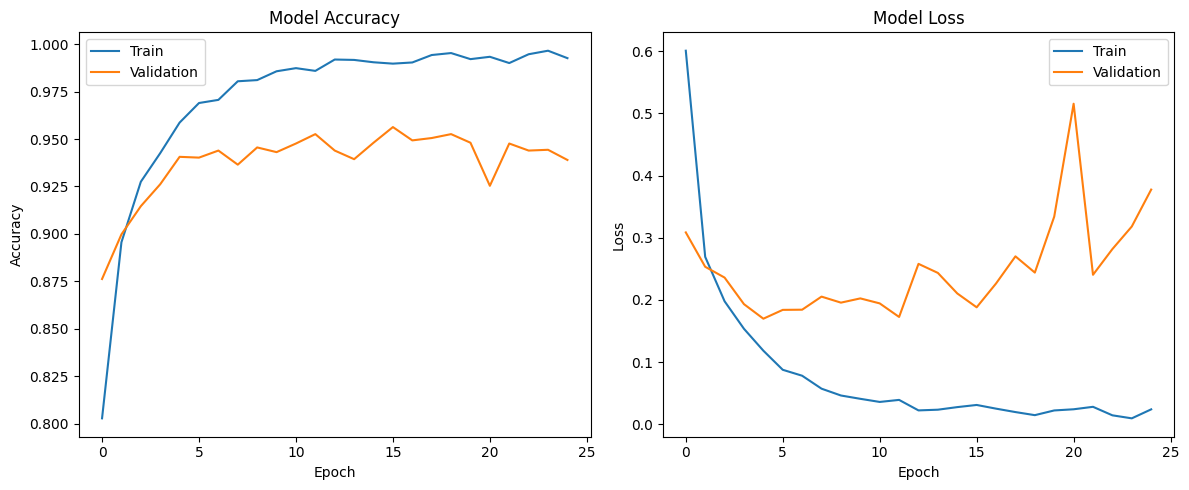

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [8]:
# Make predictions
predictions = model.predict(testX)
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class labels

# Convert testY from one-hot encoded to class labels (integers)
y_true = np.argmax(testY, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step
[[ 616  102    5]
 [  30 2006    3]
 [   1   25  243]]


In [9]:
class_names = le.classes_

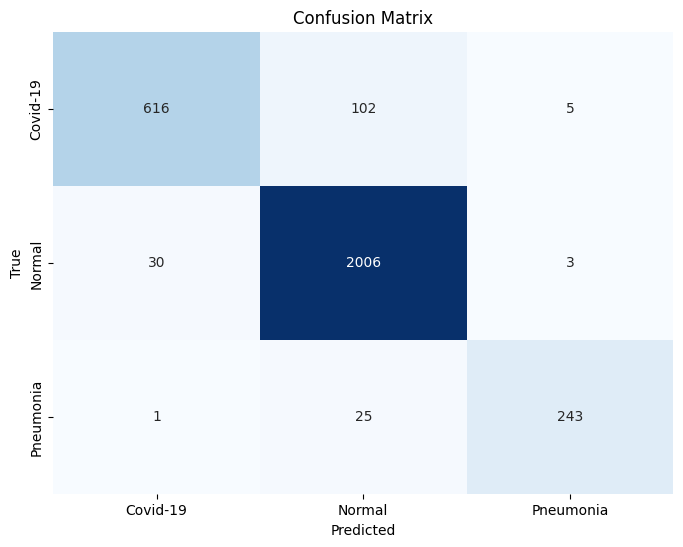

In [10]:
# Create DataFrame for the confusion matrix
Confusion_Matrix = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print(classification_report(y_true, y_pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.95209   0.85201   0.89927       723
      Normal    0.94046   0.98382   0.96165      2039
   Pneumonia    0.96813   0.90335   0.93462       269

    accuracy                        0.94523      3031
   macro avg    0.95356   0.91306   0.93184      3031
weighted avg    0.94569   0.94523   0.94437      3031



In [12]:
model.save('CNN_Covid19_Xray_Version.h5') 


import pickle

pickle.dump(le, open("Label_encoder.pkl",'wb'))
print("saved")

saved


In [18]:
import shutil
shutil.move('CNN_Covid19_Xray_Version.h5', '/kaggle/working/CNN_Covid19_Xray_Version.h5')


'/kaggle/working/CNN_Covid19_Xray_Version.h5'

In [13]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('CNN_Covid19_Xray_Version.h5')

le = pickle.load(open("Label_encoder.pkl",'rb'))

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detection_system(image_path, model, label_encoder, image_size=150):
    """
    Detection system function to classify an input image.

    Parameters:
    - image_path: The path to the image to classify.
    - model: The trained Keras model.
    - label_encoder: The LabelEncoder used to encode the labels.
    - image_size: The target size for resizing the image (default: 150x150).
    
    Returns:
    - predicted_label: The predicted class label.
    - confidence_score: The confidence score of the predicted class.
    """
    # Load the image from the provided path
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    # Convert image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    # Resize the image to the same size as the training images
    image_resized = cv2.resize(image_rgb, (image_size, image_size))
    
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    
    # Expand the dimensions to match the input shape for the model
    image_input = np.expand_dims(image_normalized, axis=0)
    
    # Predict the class of the image
    predictions = model.predict(image_input)
    
    # Get the predicted class index and confidence score
    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index]
    
    # Decode the predicted index back to the original label
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    
    
    # Display the image with the predicted label and confidence score
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


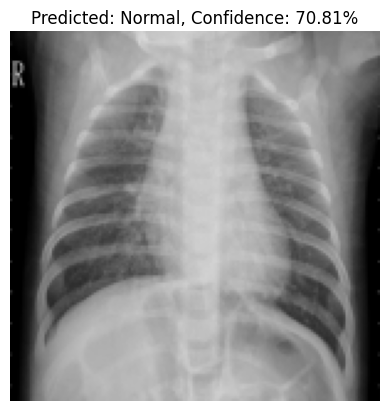

Predicted Label: Normal, Confidence Score: 70.81%


In [17]:
# Example usage
image_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-900.png"  # Replace with the path to your image
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")